# ML Pipeline Preparation
This notebook explains the steps followed to create the ML pipeline found in 'train_classifier.py' script.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download(['punkt','stopwords','wordnet'])

from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jvios\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jvios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jvios\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('select * from messages_w_categories', engine)

In [20]:
df.head()

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df['related'].value_counts()

1    19874
0     6115
2      188
Name: related, dtype: int64

In [4]:
# Remove the 188 messages with 'related' value = 2, because fiting multilabel and multiclass classification cannot be handled.
df = df.loc[df['related']!=2]
df['related'].value_counts()
# Now all labels (categories) are binary

1    19874
0     6115
Name: related, dtype: int64

In [5]:
# Let's create feature and target variables
X = df['message']
y = df.drop(columns=['message','original','genre'])

In [6]:
for i in y.columns.values.tolist():
    print (i)

related
request
offer
aid_related
medical_help
medical_products
search_and_rescue
security
military
water
food
shelter
clothing
money
missing_people
refugees
death
other_aid
infrastructure_related
transport
buildings
electricity
tools
hospitals
shops
aid_centers
other_infrastructure
weather_related
floods
storm
fire
earthquake
cold
other_weather
direct_report


### 2. Tokenization function that process text data

The function below performs the Natural Language Processing on the social media post text. It is used later when building the classifier model

In [6]:
def tokenize(text):
    """Function to clean, normalize, tokenize and lemmatize text
    
    Args:
        string (text)
    Returns:
        list of strings (clean_tokens)
    """
    #remove urls
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Remove spaces > 1
    text = re.sub(' +', ' ', text)
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    clean_tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens if w not in stopwords.words("english")]

    return clean_tokens

Let's now visualize the most common words/tokens in some selected categories:

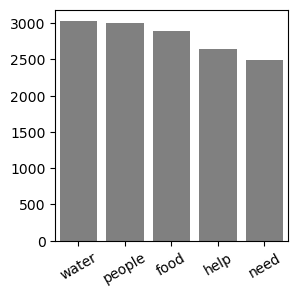

In [93]:
# All dataset, token absolute counts:
BoW = []
for i in range(len(X)):    
    BoW.extend(tokenize(X.iloc[i]))
fdist = FreqDist(BoW).most_common(5)
fdist = pd.Series(dict(fdist))
fig, ax = plt.subplots(figsize=(3,3))
plot = sns.barplot(x=fdist.index, y=fdist.values, ax=ax, facecolor='grey')
plt.xticks(rotation=30)

In [6]:
def top_5_tokens(category):
    """Function to print barplot of 5 most frequent tokens in category column in df.
        Frequency of tokens is displayed as % calculated within category and within value
    
    Args:
        string (category): column of df
    Returns:
        None
    """
    words_df = df[['message', category]]
    plt.figure(figsize=(15,5))
    value_counts = words_df[category].value_counts()
    for i in range(len(value_counts)): # loop for all values of category
        ax = plt.subplot(3, 3, i+1) 
        filtered_df = words_df.loc[words_df[category]==value_counts.index[i]]['message'] # get messages of category and value
        BoW = [] # initialize list to store tokens
        #for j in range(100): # for testing function only    
        for j in range(len(filtered_df)): 
            BoW.extend(tokenize(filtered_df.iloc[j])) # get tokens
        fdist = FreqDist(BoW).most_common(5) # get 5 most common tokens
        fdist = pd.Series(dict(fdist))
        fdist = round(100*(fdist/sum(fdist)),0).astype(int)
        fdist.plot.bar(ax=ax)
        ax.set_title("category: '{}' - value = {}".format(category,value_counts.index[i]))
        ax.set_ylabel("token frequency (%)")
        plt.xticks(rotation=30)

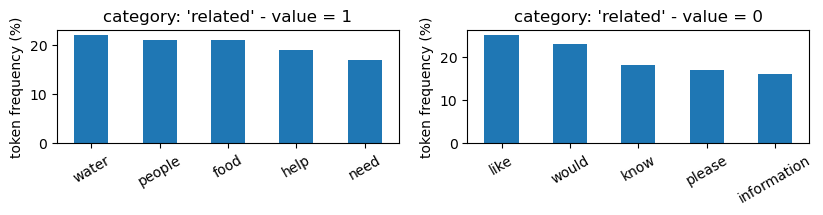

In [14]:
top_5_tokens('related')

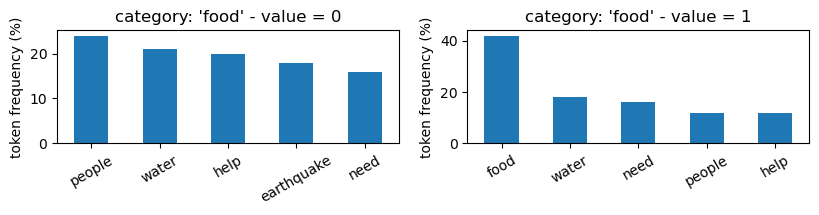

In [35]:
top_5_tokens('food')

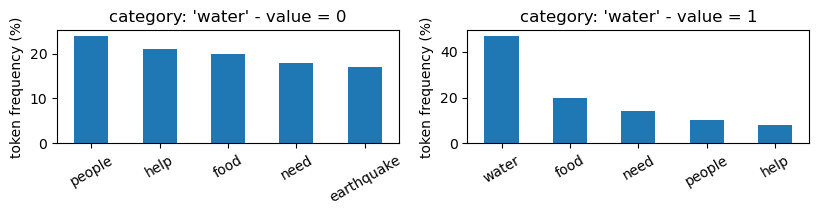

In [36]:
top_5_tokens('water')

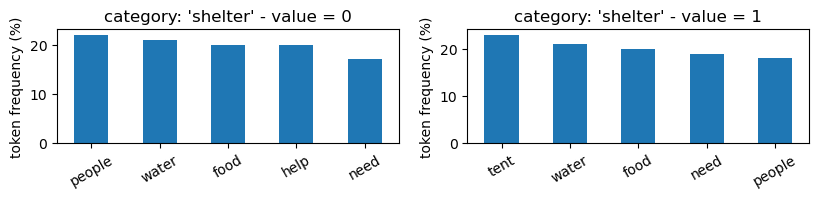

In [37]:
top_5_tokens('shelter')

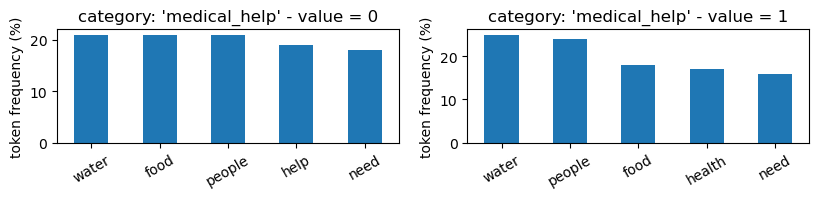

In [38]:
top_5_tokens('medical_help')

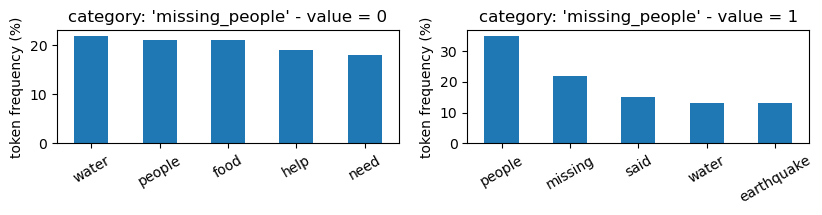

In [39]:
top_5_tokens('missing_people')

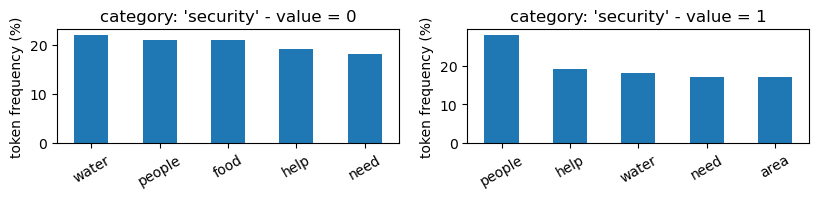

In [40]:
top_5_tokens('security')

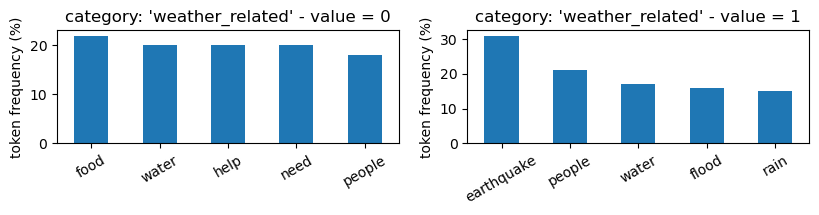

In [41]:
top_5_tokens('weather_related')

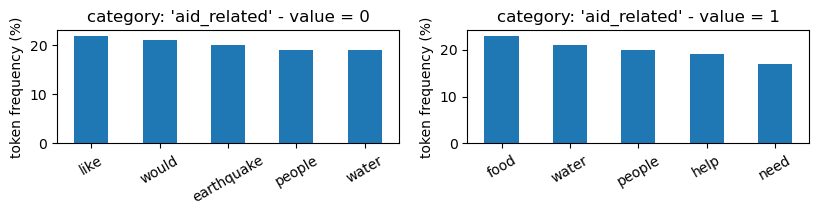

In [60]:
top_5_tokens('aid_related')

### 3. Building the machine learning pipeline
The following machine pipeline takes in the `message` column as input and output classification results on the other 36 categories in the dataset. It uses the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) to predict multiple target variables.

First I built a classifier using logistic regression. Later I optimized it using Grid Search (see below) and finally I tried other algorithms (Random Forests and Multinomial Naive Bayes)

In [7]:
# Logistic regression
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

### 5. Test the model
Let's report the f1 score, precision and recall for each output category of the dataset. To do this, I'll iterate through the columns and call sklearn's `classification_report` on each.

In [96]:
def print_classification_report(y_test,predicted):
    """Function to print 1 classification report per each category/label with all its classes
    In each report of each label, includes:
    - Precision, recall and F1 for each class of each label in y_test.
    - Weighted and unweighted (macro) averages of precision, recall and F1.
    - Accuracy (= unweighted recall)
    
    Args:
        DataFrame (y_test): test split of target values
        numpy array (predicted): values predicted by model
    Returns:
        None
    """
    for i,column in enumerate(y_test.columns):
        print("****\ncategory: " + column)
        category_values = y_test[column].value_counts().index
        print(classification_report(y_test[column],predicted[:,i], target_names = ['value: ' + str(i) for i in category_values]))

Using the function above, we see in the next cell that for many labels (=categories), the positive class (value=1) has lower performance than the negative class (value=0). Both precision, recall and f1-score are lower for class 1 than class 0, which is due to the fact that class 1 is minoritary in many categories. Indeed, in those categories in which the inbalance between classes is less pronounced (for example, 'aid-related'), precision, recall and f1-score are more similar for both classes.

In [11]:
# Classification report of logistic regression classifier:
print_classification_report(y_test,predicted)

****
category: related
              precision    recall  f1-score   support

    value: 1       0.72      0.41      0.53      1499
    value: 0       0.84      0.95      0.89      4999

    accuracy                           0.83      6498
   macro avg       0.78      0.68      0.71      6498
weighted avg       0.82      0.83      0.81      6498

****
category: request
              precision    recall  f1-score   support

    value: 0       0.91      0.97      0.94      5418
    value: 1       0.78      0.52      0.63      1080

    accuracy                           0.90      6498
   macro avg       0.85      0.75      0.78      6498
weighted avg       0.89      0.90      0.89      6498

****
category: offer
              precision    recall  f1-score   support

    value: 0       0.99      1.00      1.00      6464
    value: 1       0.00      0.00      0.00        34

    accuracy                           0.99      6498
   macro avg       0.50      0.50      0.50      6498
weighte

C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

    value: 0       1.00      1.00      1.00      6476
    value: 1       0.00      0.00      0.00        22

    accuracy                           1.00      6498
   macro avg       0.50      0.50      0.50      6498
weighted avg       0.99      1.00      0.99      6498

****
category: aid_centers
              precision    recall  f1-score   support

    value: 0       0.99      1.00      0.99      6424
    value: 1       0.00      0.00      0.00        74

    accuracy                           0.99      6498
   macro avg       0.49      0.50      0.50      6498
weighted avg       0.98      0.99      0.98      6498

****
category: other_infrastructure
              precision    recall  f1-score   support

    value: 0       0.96      1.00      0.98      6225
    value: 1       0.42      0.02      0.04       273

    accuracy                           0.96      6498
   macro avg       0.69      0.51      0.51      6498
weighted av

Note f1-score of positive class (value=1) in the following categories/labels:
- aid_related: 0.71
- medical_help: 0.23
- search_and_rescue: 0.11

## 6. Improve the model
Let's use grid search to find better parameters. Using 'get_params' methods on pipeline object, we can see that, among all parameters, there is a 'class_weight' estimator parameter that can help to account for class inbalance. It is called 'clf__estimator__class_weight' and can be set to either 'None' or 'balanced'. When set to ‘balanced’, the model automatically assigns the class weights inversely proportional to their respective frequencies.

In [12]:
# logistic regression
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x00000213830B89D0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=LogisticRegression(max_iter=200)))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x00000213830B89D0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=LogisticRegression(max_iter=200)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublin

Let's use GridSearchCV to optimize among the 2 possible values of 'clf__estimator__class_weight'. I will optimize for F1 macro, as it is more sensitive to the less frequent class, which is what we want in this particular use case. We might have chosen to optimize for recall, which would maximize the fraction of people searching for help, at the expense of increasing false positives. Thus, without domain specific information on wether it is actually preferable to optimize recall vs precision, I will optimize for F1 which is a sort of balanced optimization accounting for both parameters.

In [13]:
def build_model_LogisticRegression():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))) # default max_iter=100 raises warning 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
    ])
    
    # specify parameters for grid search
    parameters = {
        'clf__estimator__class_weight': [None,'balanced']
    }
    
    # create grid search object    
    cv = GridSearchCV(pipeline, param_grid = parameters, scoring='f1_macro')
    return cv

### 7. Test the model
Let's now see the accuracy, precision, and recall of the tuned model.

In [14]:
# Logistic regression, entire dataset. Takes 25 minutes to run
model = build_model_LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [19]:
# let's print results
print_classification_report(y_test,predicted)

****
category: related
              precision    recall  f1-score   support

    value: 1       0.56      0.78      0.65      1499
    value: 0       0.92      0.82      0.87      4999

    accuracy                           0.81      6498
   macro avg       0.74      0.80      0.76      6498
weighted avg       0.84      0.81      0.82      6498

****
category: request
              precision    recall  f1-score   support

    value: 0       0.95      0.90      0.92      5418
    value: 1       0.60      0.77      0.67      1080

    accuracy                           0.88      6498
   macro avg       0.77      0.83      0.80      6498
weighted avg       0.89      0.88      0.88      6498

****
category: offer
              precision    recall  f1-score   support

    value: 0       1.00      0.99      0.99      6464
    value: 1       0.05      0.09      0.06        34

    accuracy                           0.99      6498
   macro avg       0.52      0.54      0.53      6498
weighte

Note that f1-scores of positive class (value=1) now improves, and it improves more in those categories/labels with higher class imbalance:

| Label | Before Grid Search | After Grid Search | Class 1 support | Class 0 support |
|-------|--------------------|-------------------|-----------------|-----------------|
| aid-related | 0.71 | 0.73 | 2648 | 3850 |
| medical_help | 0.23 | 0.48 | 510 | 5988 |
| search_and_rescue | 0.11 | 0.24 | 169 | 6329 |

As a matter of fact, the best parameters are found for the 'balanced' class weight. 

In [18]:
model.best_params_

{'clf__estimator__class_weight': 'balanced'}

In [20]:
model.scorer_

make_scorer(f1_score, pos_label=None, average=macro)

### 8. Further improving the model
Let's try other machine learning algorithms to see if we can improve the results. I try below Random Forests and Multinomial Naïve Bayes algorithms:

#### Random forests

In [42]:
# random forests classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [61]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001E2555D2790>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E2555D2790>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,


In [97]:
# Building pipeline with Grid Search
def build_model_Random_Forest():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

    # specify parameters for grid search
    parameters = {
        'clf__estimator__n_estimators': [50,200],
        'clf__estimator__min_samples_split': [2,4]
    }

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, scoring='f1_macro')
    
    return cv

In [98]:
model = build_model_Random_Forest()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [100]:
model.best_params_

{'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 50}

In [101]:
# let's print results
print_classification_report(y_test,predicted)

****
category: related
              precision    recall  f1-score   support

    value: 1       0.72      0.40      0.52      1578
    value: 0       0.83      0.95      0.89      4920

    accuracy                           0.82      6498
   macro avg       0.78      0.68      0.70      6498
weighted avg       0.81      0.82      0.80      6498

****
category: request
              precision    recall  f1-score   support

    value: 0       0.90      0.98      0.94      5345
    value: 1       0.83      0.51      0.63      1153

    accuracy                           0.89      6498
   macro avg       0.87      0.74      0.79      6498
weighted avg       0.89      0.89      0.88      6498

****
category: offer
              precision    recall  f1-score   support

    value: 0       0.99      1.00      1.00      6465
    value: 1       0.00      0.00      0.00        33

    accuracy                           0.99      6498
   macro avg       0.50      0.50      0.50      6498
weighte

C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

    value: 0       0.95      1.00      0.97      6154
    value: 1       0.74      0.12      0.20       344

    accuracy                           0.95      6498
   macro avg       0.85      0.56      0.59      6498
weighted avg       0.94      0.95      0.93      6498

****
category: electricity
              precision    recall  f1-score   support

    value: 0       0.98      1.00      0.99      6371
    value: 1       0.83      0.04      0.08       127

    accuracy                           0.98      6498
   macro avg       0.91      0.52      0.53      6498
weighted avg       0.98      0.98      0.97      6498

****
category: tools
              precision    recall  f1-score   support

    value: 0       0.99      1.00      1.00      6458
    value: 1       0.00      0.00      0.00        40

    accuracy                           0.99      6498
   macro avg       0.50      0.50      0.50      6498
weighted avg       0.99   

C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jvios\anaconda3\lib\site-packages\sklearn\metr

Let's compare f1 scores for positive class in selected labels with logistic regression and random forests (after grid search). Logistic regression seems to outperform Random Forests (more on this later).

| Label | Random Forests | Logistic regression | 
|-------|--------------------|-------------------|
| aid-related | 0.73 | 0.73 |
| medical_help | 0.16 | 0.48 | 
| search_and_rescue | 0.21 | 0.24 | 

#### Multinomial Naive Bayes

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

In [107]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

In [108]:
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

In [109]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x0000029ACB279280>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=MultinomialNB()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x0000029ACB279280>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=MultinomialNB()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf':

I introduce alpha as grid search parameter to prevent zero class probabilities due to words not present in the train set

In [112]:
def build_model_MultinomialNaiveBayes():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(MultinomialNB()))
    ])

    # specify parameters for grid search
    parameters = {
        'clf__estimator__alpha': [0.001, 1, 100]
    }

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, scoring='f1_macro')
    
    return cv

In [113]:
model = build_model_MultinomialNaiveBayes()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [114]:
model.best_params_

{'clf__estimator__alpha': 0.001}

In [115]:
# let's print results
print_classification_report(y_test,predicted)

****
category: related
              precision    recall  f1-score   support

    value: 1       0.65      0.40      0.50      1527
    value: 0       0.84      0.93      0.88      4971

    accuracy                           0.81      6498
   macro avg       0.74      0.67      0.69      6498
weighted avg       0.79      0.81      0.79      6498

****
category: request
              precision    recall  f1-score   support

    value: 0       0.91      0.94      0.92      5351
    value: 1       0.66      0.58      0.62      1147

    accuracy                           0.87      6498
   macro avg       0.79      0.76      0.77      6498
weighted avg       0.87      0.87      0.87      6498

****
category: offer
              precision    recall  f1-score   support

    value: 0       1.00      1.00      1.00      6469
    value: 1       0.00      0.00      0.00        29

    accuracy                           1.00      6498
   macro avg       0.50      0.50      0.50      6498
weighte

Let's compare f1 scores for positive class in selected labels with logistic regression, random forests and multimomial naive bayes classifiers (after grid search)

| Label | Multinomial Naive Bayes | Random Forests | Logistic regression | 
|-------|-------------------------|----------------|---------------------|
| aid-related | 0.66 | 0.73 | 0.73 |
| medical_help | 0.24 | 0.16 | 0.48 | 
| search_and_rescue | 0.04 | 0.21 | 0.24 | 

It seems logistic regression gives the best f1 macro score for the positive class (value=1) accross several categories/labels

#### Comparison of the different models

Let's have a more comprehensive and global overview of the results of the 3 models (logistic regression, random forests and multinomial naive bayes) by looking at the precision, recall, f1 and accuracy averaged (macro) across all labels/categories:

| Parameter | Multinomial Naive Bayes | Random Forests | Logistic regression | 
|--------------------------------------------------------|--|--|--|
| Precision (average of macro averages for all labels)   | 0.67 | 0.79 | 0.68 |
| Recall (average of macro averages for all labels)      | 0.59 | 0.59 | 0.76 | 
| F1 score (average of macro averages for all labels)    | 0.61 | 0.61 | 0.70 |
| Accuracy (average of weighted averages for all labels) | 0.93 | 0.95 | 0.93 |

CONCLUSION: we consistently see across models a relatively high accuracy and low recall, due to high class imbalance across many labels. We also see that Multimnomial Naive Bayes performs the worst for all the 4 parameters. If we want to maximize precision, we should take the Random Forests classifier. If we want to maximize recall, we should go for the Logistic Regression model. If, as said before, we want to maximize a balance between precision and recall, we would choose the highest F1 score and thus also go for the Logistic Regression classifier, which is the one that has been used in deployment in the 'train_classifier.py' script. The drawback with the Logistic Regression model is that, given its low overall precision (0.68), it will yield a relatively high amount of false positives (i.e. it will incorrectly label input messages assigning them to categories that do not really correspond), however, at least, it will catch most of the true positive rescue enquiry messages given its relatively high overall recall (0.76).

### 9. Exporting model as a pickle file

We'll save the trained model as a pickle file that can be used by the website app to quickly analyze input text according to the saved classifier. To do that, all we need to do is pass the model object into the dump() function of Pickle. This will serialize the object and convert it into a “byte stream” that we can save as a file. The file called 'model.pkl' contains the logistic regression model.

In [22]:
pickle.dump(model, open('model.pkl', 'wb'))

In [99]:
pickle.dump(model, open('classifier_random_forest.pkl', 'wb'))

In [116]:
pickle.dump(model, open('classifier_multinomial_naive_bayes.pkl', 'wb'))

To load a saved model from a Pickle file, all you need to do is pass the “pickled” model into the Pickle load() function and it will be deserialized. By assigning this back to a model object, you can then run your original model’s predict() function, pass in some test data and get back an array of predictions, as explained [here](https://practicaldatascience.co.uk/machine-learning/how-to-save-and-load-machine-learning-models-using-pickle)

### 10. Use this notebook to complete `train.py`

All the steps in this notebook have been placed in a python script called `train_classifier.py`, which is found in the folder 'models'. Such file creates a database and alows to export a model based on a new dataset specified by the user.